In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import requests
import json

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from statsmodels.formula.api import logit

# utilities
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, auc
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict

#customizations
plt.style.use('ggplot')
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (18, 8)
plt.rcParams['text.color'] = 'k'

In [15]:
logins = pd.read_json('logins.json')
logins['login_amt'] = 1
logins.head()

,login_time,login_amt
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


# PART 1 - Exploratory Data Analysis

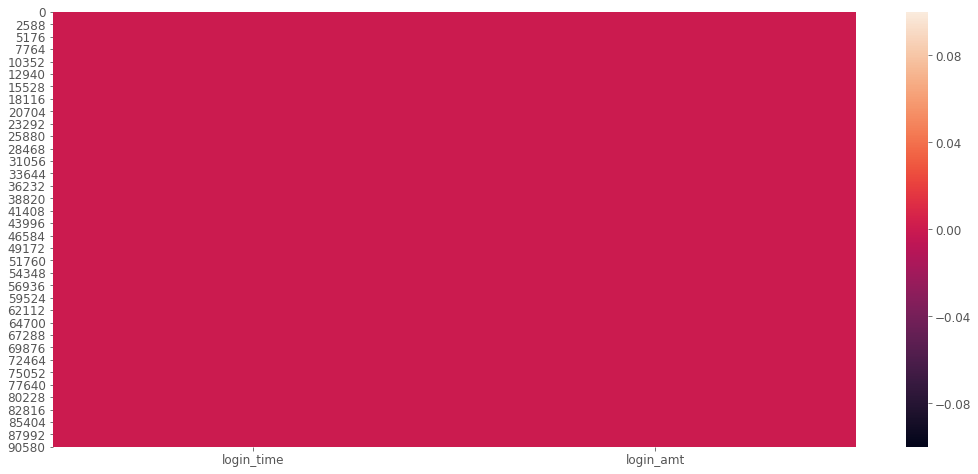

In [74]:
sns.heatmap(logins.isnull())

No missing data in the logins table

In [17]:
logins_15m = logins.set_index('login_time').resample('15T').sum()
logins_15m.head()

,login_amt
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [68]:
logins_15m['MA50'] = logins_15m['login_amt'].rolling(50).mean()
logins_15m['MA2000'] = logins_15m['login_amt'].rolling(2000).mean()

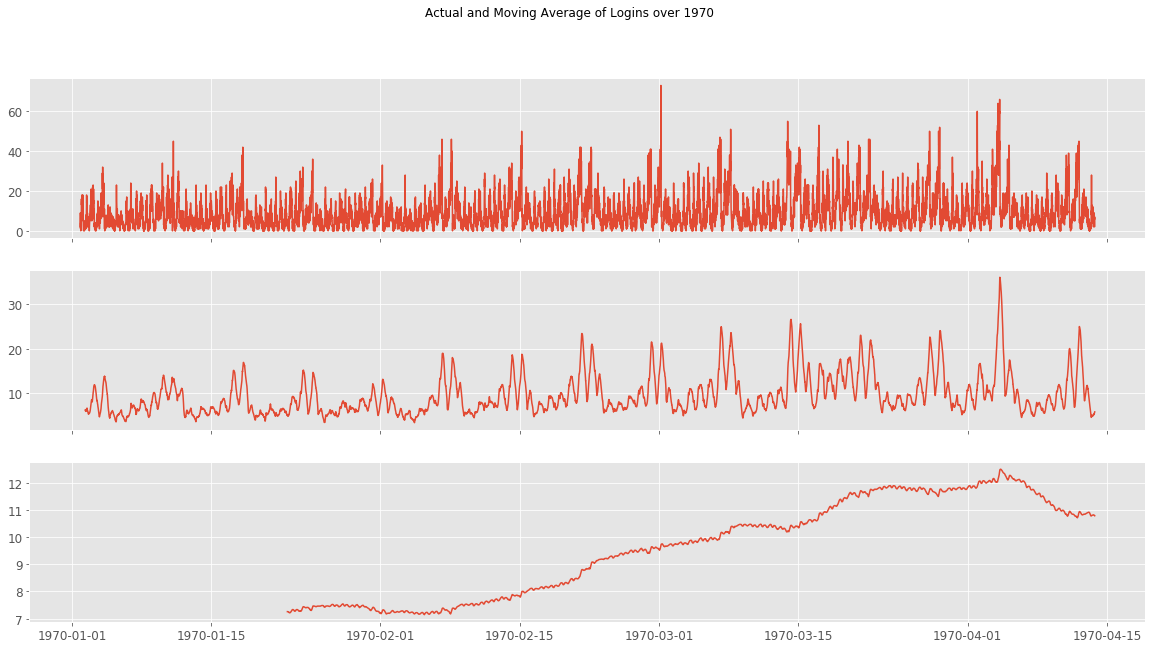

In [72]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=[20,10], sharex=True)
fig.suptitle('Actual and Moving Average of Logins over 1970')
ax1.plot(logins_15m.login_amt)
ax2.plot(logins_15m.MA5)
ax3.plot(logins_15m.MA2000);

From the above plot you can see that the moving average reveals the presence of weekly seasonality with similar looking spikes. There also seems to be a multiplicative effect as the spikes seem to grow more pronounced over the months. Thirdly, in the bottom plot of the above figure there is an upwards trend of logins over the year as well.

# Part 2 ‑ Experiment and metrics design

1. I would choose the mean value of drivers that cross the bridge on a daily basis because its a good indication of the number of people using the bridge while mitigating the effect of outliers.

2. a) I would set it up so that reimbursment would only occur on even days of the calendar. In this manner, we would have 2 groups, one being drivers that use the bridge on even days, and ones that drive on odd days. The advantage of this method is that any big event that could influence the use of the bridge (natural disastor) would influence both groups simultaneously. 

2. b) I would perform a two sample z-test to make sure that the mean value of drivers on odd days, equal the mean value of drivers that drive on even days



+ Null hypothesis: the mean values are the same, and the reimbursement has no effect on increasing drivers on the bridge
+ Alternative hypothesis: the mean values of drivers that get a reibursement is more than when they don't so the reimbursement has an effect on increasing the driver usage.

2. c) if in the case that we reject the null hypothesis in favor of the alternative hypothesis, then it would prove that the toll of the bridge is preventing drivers from wanting to use the bridge. The recommendation would be to remove the toll, but that is not realistic so I would instead do further tests on what is the optimal toll price to get an acceptable number of drivers to use the bridge

# Part 3 ‑ Predictive modeling

In [249]:
with open('ultimate_data_challenge.json') as f:
   data = json.load(f)
df = pd.DataFrame(data)
print(df.shape)
df.head(20)

(50000, 12)


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,True,100.0,10.56,5.0
6,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,Android,0.0,False,100.0,3.95,4.0
7,Winterfell,2,2014-01-28,5.0,1.00,2014-01-29,iPhone,0.0,False,100.0,2.04,5.0
8,Winterfell,2,2014-01-21,4.5,1.00,2014-02-01,Android,0.0,False,100.0,4.36,5.0
9,Winterfell,1,2014-01-03,NaN,1.00,2014-01-05,Android,0.0,False,0.0,2.37,5.0


## Cleaning

In [205]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

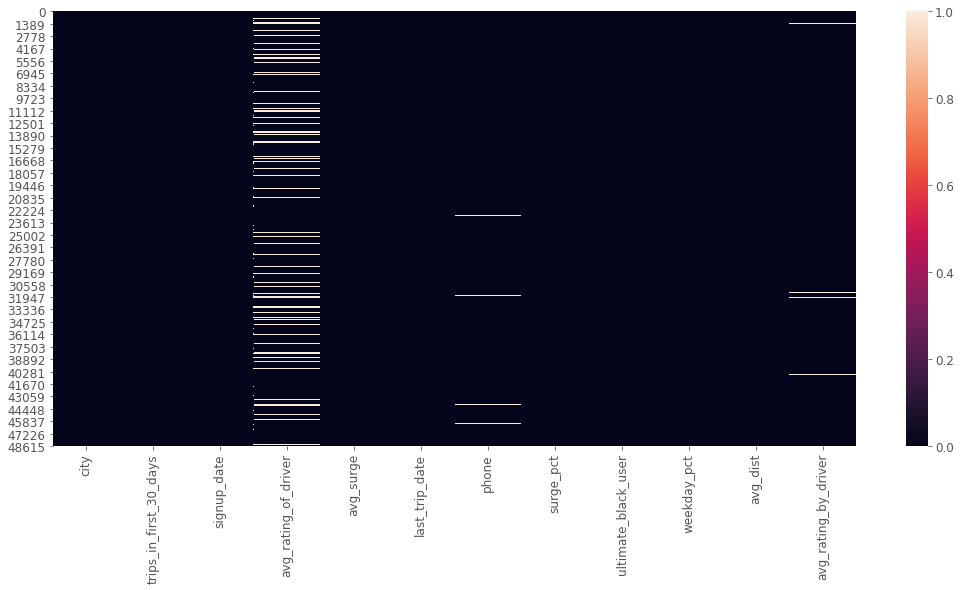

In [206]:
sns.heatmap(df.isnull())

From looking at the heatmap of null values I could tell that I would not be able to impute the missing values with methods like bfill, ffill, or taking the mean without adding too much noise to the dataset. This especially applies to the average rating of the driver. If I were to replace the missing values with the mean rating, then I'd be adding noise to about 20% of the dataset which is fairly significant. Since we have a lot of data, I was willing to let go of the null values.

In [207]:
df = df.dropna()
retained = df.shape[0]/50000 *100
print('Retained number of rows is %.2f percent of the original dataset' % retained)

Retained number of rows is 82.89 percent of the original dataset


## Preprocessing

In [208]:

df['membership_length'] = (df.last_trip_date - df.signup_date).dt.days
df['ultimate_black_user'] = df['ultimate_black_user']*1

#Response variable
df['retention_status'] = df.trips_in_first_30_days.apply(lambda x: 0 if x > 0 else 1)

## Feature Engineering

In [209]:
drop_cols = df.dtypes[(df.dtypes== 'object') | (df.dtypes=='datetime64[ns]')].index
encoded_cols = pd.get_dummies(df[['city', 'phone']], drop_first=True)

df = df.drop(drop_cols, axis='columns')
df = pd.concat([df,encoded_cols], axis='columns')

## EDA

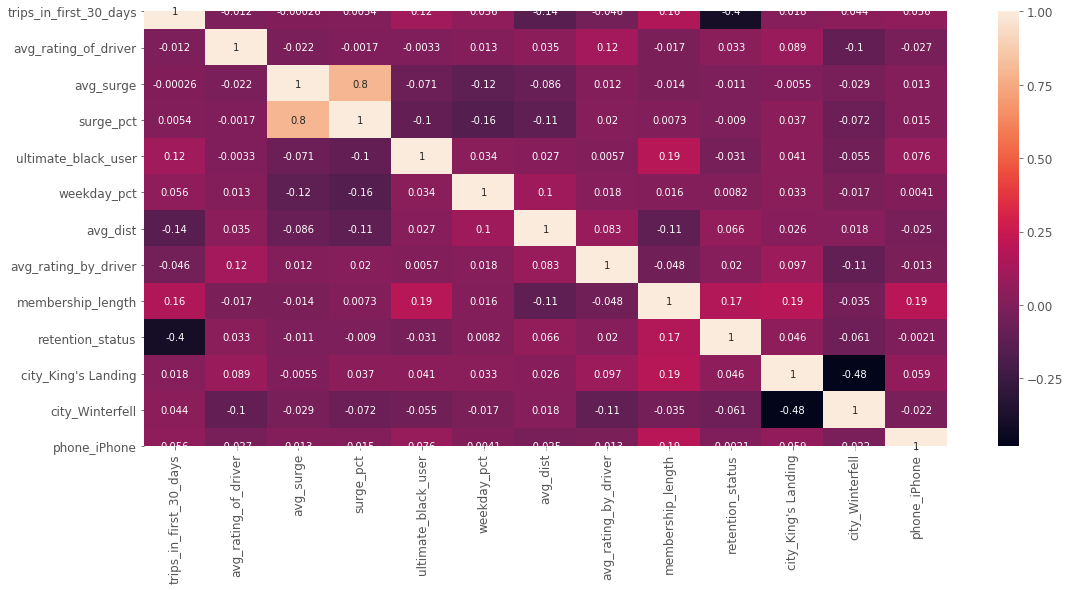

In [211]:

sns.heatmap(df.corr(), annot=True);

We will be removing surge_pct due to its high collinearity with avg_surge

In [212]:
df= df.drop('surge_pct', axis='columns')

Text(0.5, 1.0, 'Distribution of the average distance')

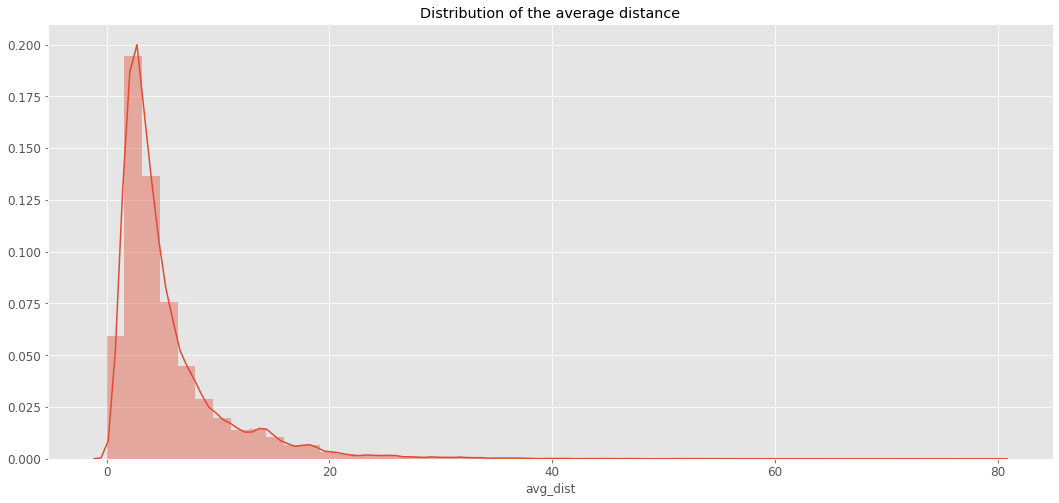

In [83]:
sns.distplot(df.avg_dist)
plt.title('Distribution of the average distance')

Text(0.5, 1.0, 'Distribution of the driver ratings')

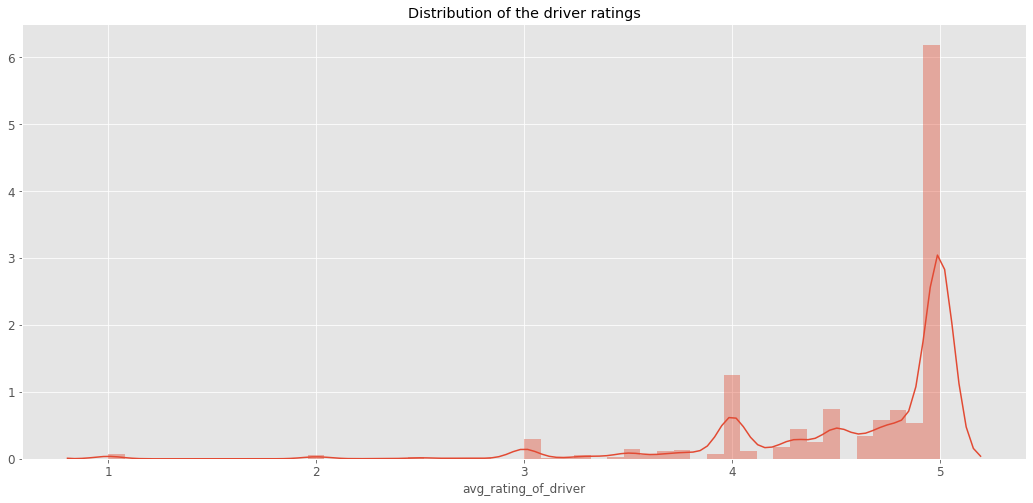

In [86]:
sns.distplot(df.avg_rating_of_driver)
plt.title('Distribution of the driver ratings')

From looking at the above distribution plot I can see that it is heavily skewed to the left, and there are practically no scores under 4. This makes it hard to trust this column as people are trying to be nice. 

Text(0.5, 1.0, 'Distribution trips_in_first_30_days')

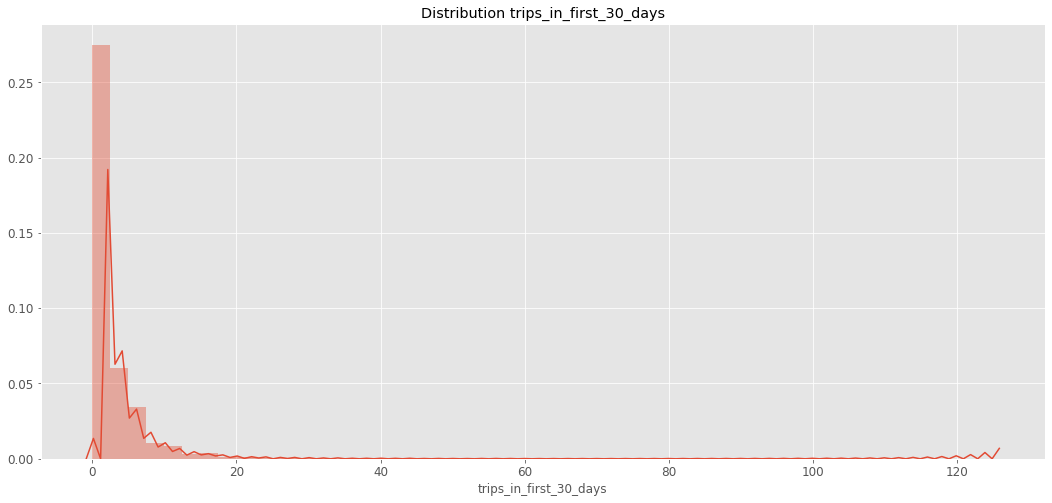

In [131]:
sns.distplot(df.trips_in_first_30_days)
plt.title('Distribution trips_in_first_30_days')


## Modeling

In [225]:
X = df.drop(['retention_status', 'trips_in_first_30_days'], axis='columns')
y=df['retention_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [246]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Z:\Users\Don\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



We will be choose logistic regression for our model because of how interpretable the results are. We will use the coefficients that the model assigns the features to determine how useful it is to maximize customer retention

In [253]:
print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.72      0.99      0.84     20919
           1       0.60      0.02      0.04      8092

    accuracy                           0.72     29011
   macro avg       0.66      0.51      0.44     29011
weighted avg       0.69      0.72      0.62     29011



In [251]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.99      0.84      9002
           1       0.55      0.02      0.04      3432

    accuracy                           0.73     12434
   macro avg       0.64      0.51      0.44     12434
weighted avg       0.68      0.73      0.62     12434



The model is validated by the train_test_split method used during the begining of the modeling phase which sets aside unseen data for the model to predict on. Based on the scores above on the training and test sets, we can see that the scores are not too different which implies that it does well in having a low variance. This model could be further improved with hyperparameter tuning and further feature engineering

In [245]:
pd.DataFrame(zip(df.columns, np.exp(model.coef_[0])), columns=['column name','Coefficient']).sort_values(by='Coefficient', ascending=False)

,column name,Coefficient
0,trips_in_first_30_days,1.106192
5,avg_dist,1.059714
4,weekday_pct,1.040637
6,avg_rating_by_driver,1.008065
3,ultimate_black_user,0.999871
1,avg_rating_of_driver,0.952018
7,membership_length,0.873807
9,city_King's Landing,0.852034
8,retention_status,0.719052
2,avg_surge,0.699817


Based on the coefficient values above, I'd say that their engagement with the service in the first 30 days is the most important thing to retain them as a customer. I suggest to further improve customer experience and satisfaction during the first month, there can be promtions and discounts. This way the customer would be more likely to continue using the service past the 1 month mark